In [ ]:
from tqdm.notebook import tnrange
from numpy import ndarray, linspace, argmax
import numpy as np
import pandas as pd
from scipy.stats import bernoulli
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
sns.set()

In [ ]:
# Utility function under CARA 
def Utility_CARA(WT,a):
    return (1-np.exp(-a*WT))/a

# utility reward function for training
def RewardFunction(Wt,a,gamma):
    return -(np.exp(-a*Wt))/a

# generate one step risky asset price return
def Yt(a,b,p,n=1):
    return bernoulli.rvs(size = n,p = p)*(a-b)+b
  
def check_position(array, number):
  '''
  helper function to check largest index(position) of closest number in an array which is smaller than a specific number 
  e.g. check_position([1,2,3,4],2.5) = 1 
       as 2.5 is is greater than 2 in the array and return index 1
  '''
  # max index with the value less than required number
  return np.max(np.where(array <=number)) if array[0] <= number else 0


def best_action_lookup(Qt, St,s_range, a_range):
  '''
  look up best action based on Q value table (Qt) and current state (St)
  '''

  #find the index of current state in the Q value table
  rounded_state = check_position(s_range, St)

  #retrive Q value for all action given state St , that is Q(s,a|s = St)
  Qt_state = Qt[rounded_state][:]
  
  #select the best action index based the the largest Q value. randonly choose on among the actions with tied Q value
  action_idx = np.random.choice(np.where(Qt_state == Qt_state.max())[0]) 
  action = a_range[action_idx]
  return action

def new_epsilon_greedy(epsilon,a_t):
    #Epsilon Greedy policy 
    choice = bernoulli.rvs(p = 1 - epsilon)
    if choice == 0:
        # print("explore")
        return np.random.uniform(high = 1)
    else:
      return a_t


In [ ]:
# Tabular Q learning
printstep = False

def trainTabularQlearning(W_0,T,alpha,gamma,a,A,B,r,p,n):
    final_Utility = []
    final_wealth = []
    action_list = np.zeros(shape = (n,T))

    s_n = 100                     # discretize state space size
    a_n = 500                      # discretize action space size
    
    s_range = linspace(start = -20, stop = 50, num = s_n, endpoint = False)
    a_range = linspace(start = -10, stop = 50, num = a_n+1, endpoint = True)          # action as a % of current wealth

    # tabular Q table, initialized with zeros
    Q_tab = np.zeros(s_n * (a_n+1)).reshape(s_n,a_n+1)
    
    for episode in tnrange(0,n):
        
        epsilon = 0.05

        #Initial State S
        W_t = W_0 

        for step in range(0,T):
            
            
            # select best acution based on current state W_t
            best_action = best_action_lookup(Q_tab, W_t,s_range, a_range)

            # apply epsilon greedy strategy
            xt = new_epsilon_greedy(epsilon, best_action)

            # get index of action vector for current action (allocation %)
            xt_idx = check_position(a_range, xt)

            # generate current step price dynamic
            Y_t = Yt(A,B,p)

            # Observe S' 
            W_t1 = (xt*W_t*(1+Y_t)+(W_t-W_t*xt)*(1+r))[0]
            

            # get index of state vector for previous state
            Wt_idx = check_position(s_range,W_t)

            # get index of state vector for new state
            Wt1_idx = check_position(s_range,W_t1)

            # Observe R
            R_t = RewardFunction(W_t1,a,gamma) if (step + 1) == T else 0
            
            # Qlearning: Q value table update: Q(s,a) <- Q(s,a) + a*( r + gamma * max_a( Q(s',a) ) - Q(s,a) )
            Q_tab[Wt_idx][xt_idx] = Q_tab[Wt_idx][xt_idx] + alpha*(R_t + gamma*np.max(Q_tab[Wt1_idx][:]) - Q_tab[Wt_idx][xt_idx] )
            
            # S <- S'
            W_t = W_t1

            action_list[episode, step] = xt

   
        final_Utility.append(Utility_CARA(W_t1,a))
        final_wealth.append(W_t1)
        # action_history = action_history.append(pd.DataFrame(np.array(action_list).reshape(1,-1) ))
 
    # plot final wealth by episodes
    fig, ax = plt.subplots(1, 1, sharex='col')
    ax.plot(final_wealth,color = "red")
    ax.set_title("Final Wealth at T = 10")

    plt.gcf()
    return Q_tab, final_wealth, action_list,s_range, a_range

  0%|          | 0/200000 [00:00<?, ?it/s]

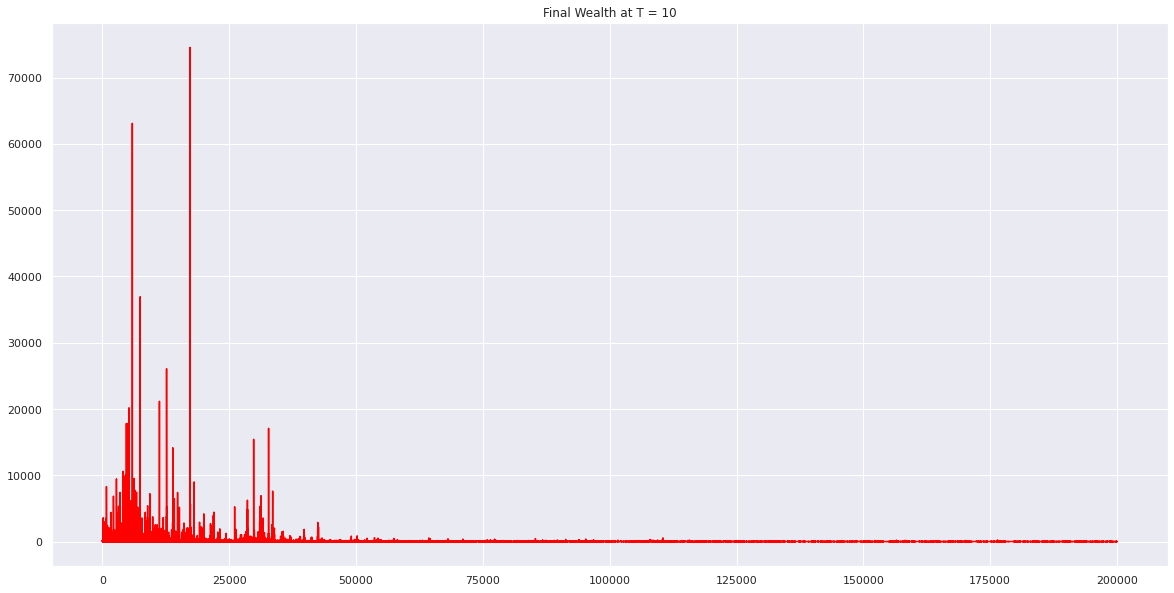

In [ ]:
# Parameter setup 
W_0 = 1                     # initial wealth
T = 10                      # Time Step
alpha = 0.2                 # learning rate in TD
gamma = 1                   # Discount rate in TD
n = 200000                   # number of episodes
A = 0.08                   # return of risky asset with probability p
B = 0.02                     # return of risky asset with probablity 1-p
interest = 0.03            # riskfree interest rate
p = 0.6                       # probability of risky asset
a: float = 1.0              # risk aversion parameter

q_table, final_wealth, action , s_range, a_range = trainTabularQlearning(W_0,T,alpha,gamma,a,A,B,interest,p,n)

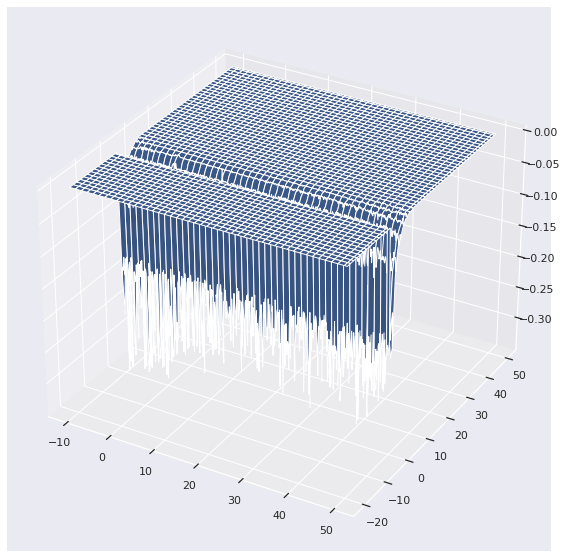

In [ ]:
# plot Q function by states and action spaces
X,Y = np.meshgrid( a_range,s_range)
data = q_table

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')

ha.plot_surface(X, Y, data)
plt.rcParams['figure.figsize'] = [20, 10]
plt.show()


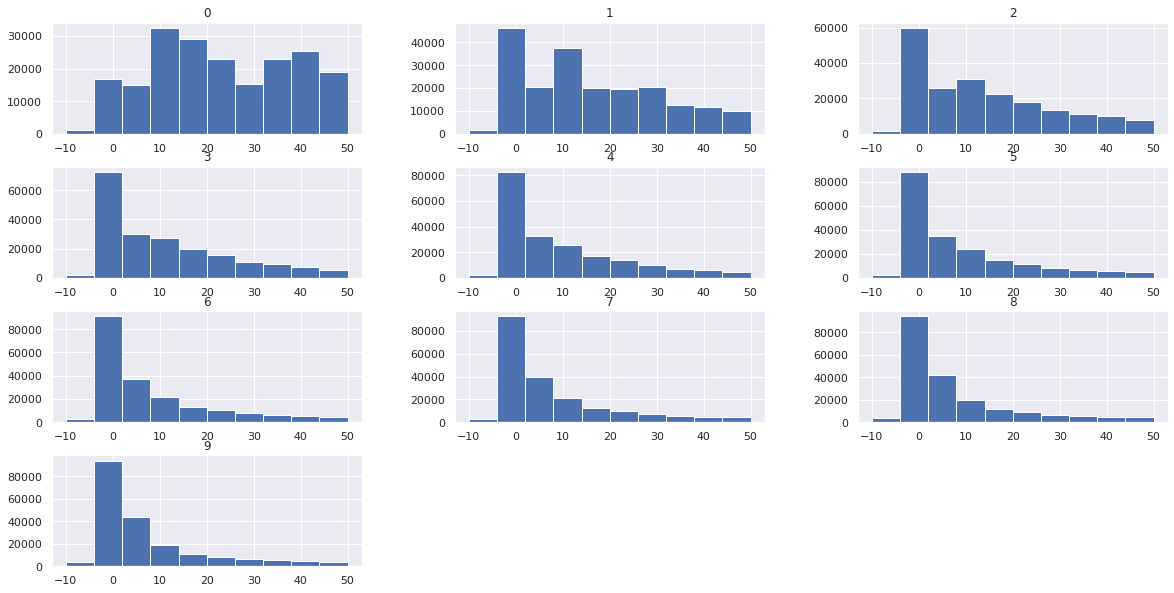

In [ ]:
# plot histogram of action selected by policy
import pandas as pd
pd.DataFrame(action).hist()
plt.show()

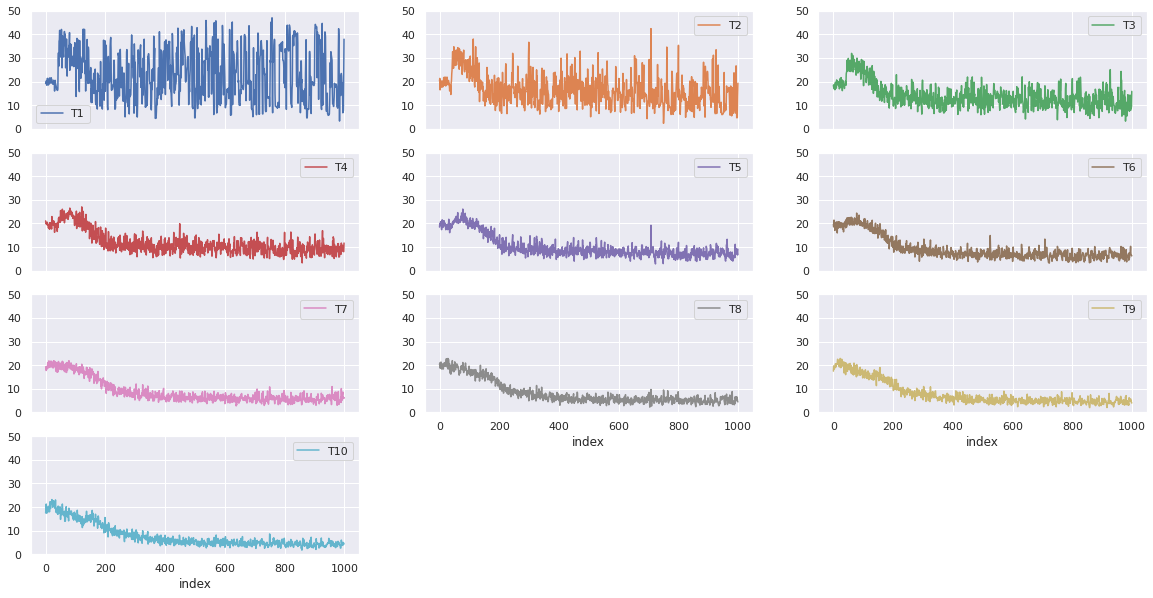

In [ ]:
# Action selected by policy over epsiodes (average action by each 1000 bin)
action_table = pd.DataFrame(action)
action_table.columns = ["T"+str(i+1) for i in action_table.columns]
action_table = action_table.reset_index()
action_table['index'] = (action_table['index']/200).astype(int)              # bin every 200 episode

t2 = action_table.groupby("index").mean() 
t2.plot(subplots = True, layout=(4,3),ylim = (0,50))


plt.show()
